In [1]:
import time
start_time = time.time()

In [2]:
import logging
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.spatial.distance import cdist
import scipy.stats as stats

from sklearn.linear_model import LinearRegression

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
from thinning import gaussian_thin, laplace_approximation
import utils.caching
from utils.caching import make_cached_s3
from utils.parallel import get_map_parallel_joblib
from utils.paths import S3_BUCKET_NAME
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
cached = make_cached_s3(S3_BUCKET_NAME)

In [6]:
map_parallel = get_map_parallel_joblib(multiprocessing.cpu_count())

Input parameters

In [7]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

In [8]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [9]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_samples(i) -> np.ndarray:
    raise NotImplementedError

In [10]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_thinned_idx(i) -> np.ndarray:
    raise NotImplementedError

In [11]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def validation_hmc_samples(i) -> np.ndarray:
    raise NotImplementedError

In [12]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def rw_log_p(i) -> np.ndarray:
    raise NotImplementedError

In [13]:
@cached(batch_size=lotka_volterra.n_chains, read_only=True)
def hmc_log_p(i) -> np.ndarray:
    raise NotImplementedError

In [14]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [15]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

## Full sample

### Elliptic distributions

In [16]:
i = 0
sample = rw_samples[i]
sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
ref_idx = np.argmax(rw_log_p[i])
sample_mode = sample[ref_idx]
rescale_matrix = np.linalg.inv(scipy.linalg.sqrtm(sample_cov))
sample_rescaled = np.einsum('kj,ij->ik', rescale_matrix, sample)

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_log_p_0.npy


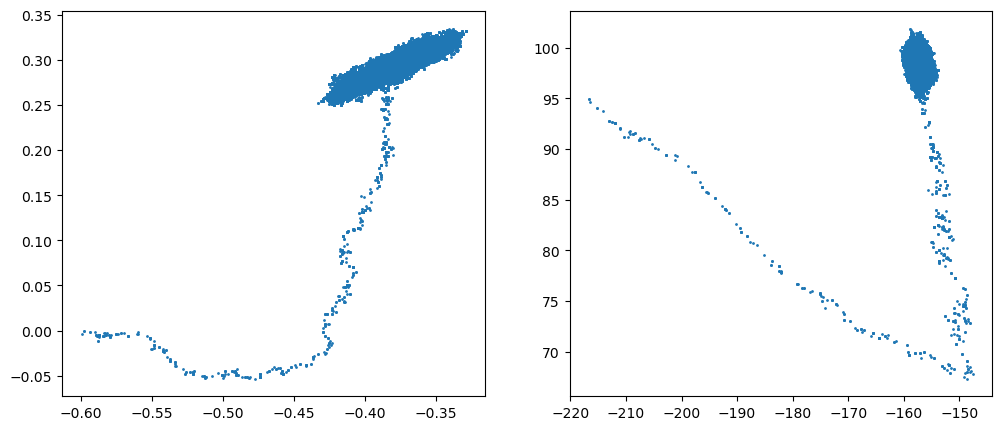

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(sample[:, 0], sample[:, 1], s=1);
axs[1].scatter(sample_rescaled[:, 0], sample_rescaled[:, 1], s=1);

In [18]:
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(sample, axis=0))

In [19]:
dists = cdist(sample_rescaled[ref_idx].reshape(1, -1), sample_rescaled).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

In [20]:
log_p_normal = stats.multivariate_normal.logpdf(sample, mean=sample[ref_idx], cov=sample_cov)
prob_diff_normal = log_p_normal - log_p_normal[ref_idx]

In [21]:
log_p_laplace_approx = stats.multivariate_normal.logpdf(sample, mean=laplace_mean, cov=laplace_cov)
prob_diff_laplace_approx = log_p_laplace_approx - log_p_laplace_approx[ref_idx]

In [22]:
cond = prob_diff > -2200

In [23]:
reg = LinearRegression().fit((dists[cond] ** 2).reshape(-1, 1), prob_diff[cond])
reg.coef_

array([-1.67595707])

In [24]:
reg.intercept_

np.float64(2.2196883567958863)

In [25]:
fitted_mean = sample_mode
fitted_cov = sample_cov * 1.15
log_p_fit = stats.multivariate_normal.logpdf(sample, mean=sample_mode, cov=fitted_cov)
prob_diff_fit = log_p_fit - log_p_fit[ref_idx]

In [26]:
entries = {
    'Sample': prob_diff,
    'Simple Gaussian': prob_diff_normal,
    'Laplace approximation': prob_diff_laplace_approx,
    'Adjusted Gausian': prob_diff_fit,
}

In [27]:
def plot_prob_diff(ax, dists, entries, xlim=None, ylim=None):
    for key, value in entries.items():
        ax.scatter(dists ** 2, value, s=1, label=key);
    ax.set_xlabel('$\\|\\Sigma^{-1/2}(x - x^*) \\|^2$');
    ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim);
    lgnd = ax.legend();
    for handle in lgnd.legend_handles:
        handle.set_sizes([15])

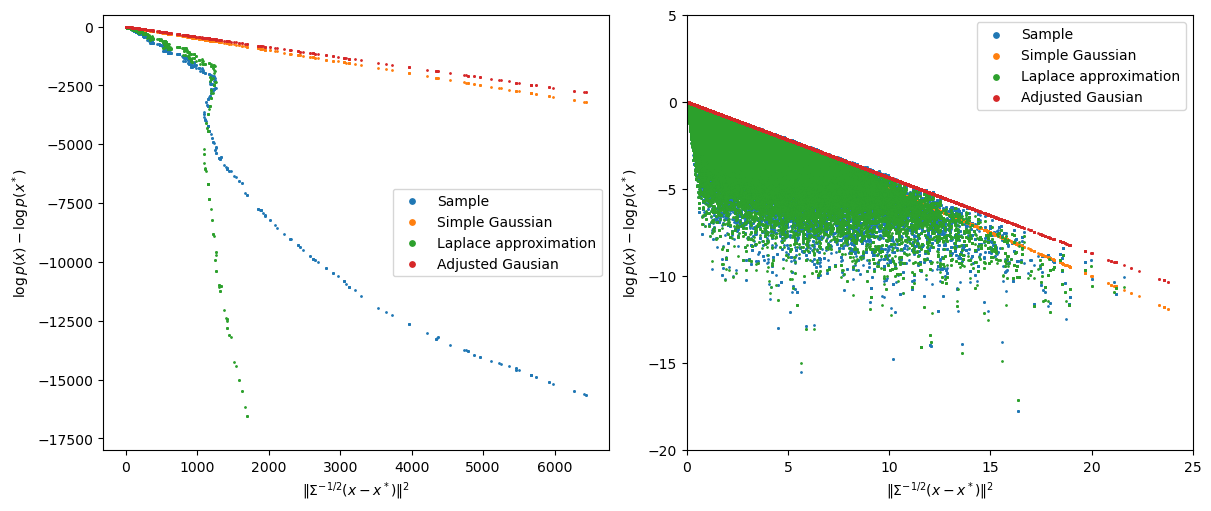

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plot_prob_diff(axs[0], dists, entries, ylim=[-18000, 500])
plot_prob_diff(axs[1], dists, entries, xlim=[0, 25], ylim=[-20, 5])

In [29]:
lims_large = [
    (None, (-18000, 500)),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
]
lims_small = [
    ((0, 25), (-20, 5)),
    ((0, 20), (-20, 5)),
    ((0, 25), (-20, 5)),
    ((0, 3), (-15, 5)),
    ((0, 20), (-20, 5)),
]
cov_multipliers = [1.15, 1.10, 1.0, 0.12, 1.05]

In [30]:
def plot_chain(i, axs):
    sample = rw_samples[i]
    sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
    ref_idx = np.argmax(rw_log_p[i])
    sample_mode = sample[ref_idx]
    rescale_matrix = np.linalg.inv(scipy.linalg.sqrtm(sample_cov))
    sample_rescaled = np.einsum('kj,ij->ik', rescale_matrix, sample)

    dists = cdist(sample_rescaled[ref_idx].reshape(1, -1), sample_rescaled).squeeze()
    prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

    log_p_normal = stats.multivariate_normal.logpdf(sample, mean=sample[ref_idx], cov=sample_cov)
    prob_diff_normal = log_p_normal - log_p_normal[ref_idx]

    fitted_mean = sample_mode
    fitted_cov = sample_cov * cov_multipliers[i]
    log_p_fit = stats.multivariate_normal.logpdf(sample, mean=sample_mode, cov=fitted_cov)
    prob_diff_fit = log_p_fit - log_p_fit[ref_idx]

    entries = {
        'Sample': prob_diff,
        'Simple Gaussian': prob_diff_normal,
        'Adjusted Gaussian': prob_diff_fit,
    }

    plot_prob_diff(axs[0], dists, entries, xlim=lims_large[i][0], ylim=lims_large[i][1])
    plot_prob_diff(axs[1], dists, entries, xlim=lims_small[i][0], ylim=lims_small[i][1])

DEBUG:utils.caching:Reading from disk cache: rw_samples_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_1
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_log_p_1.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_2
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_log_p_2.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_3
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_log_p_3.npy
DEBUG:utils.caching:Reading from disk cache: rw_samples_4
DEBUG:utils.caching:Reading gradient-free-mcmc-postprocessing/rw_samples_4.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p

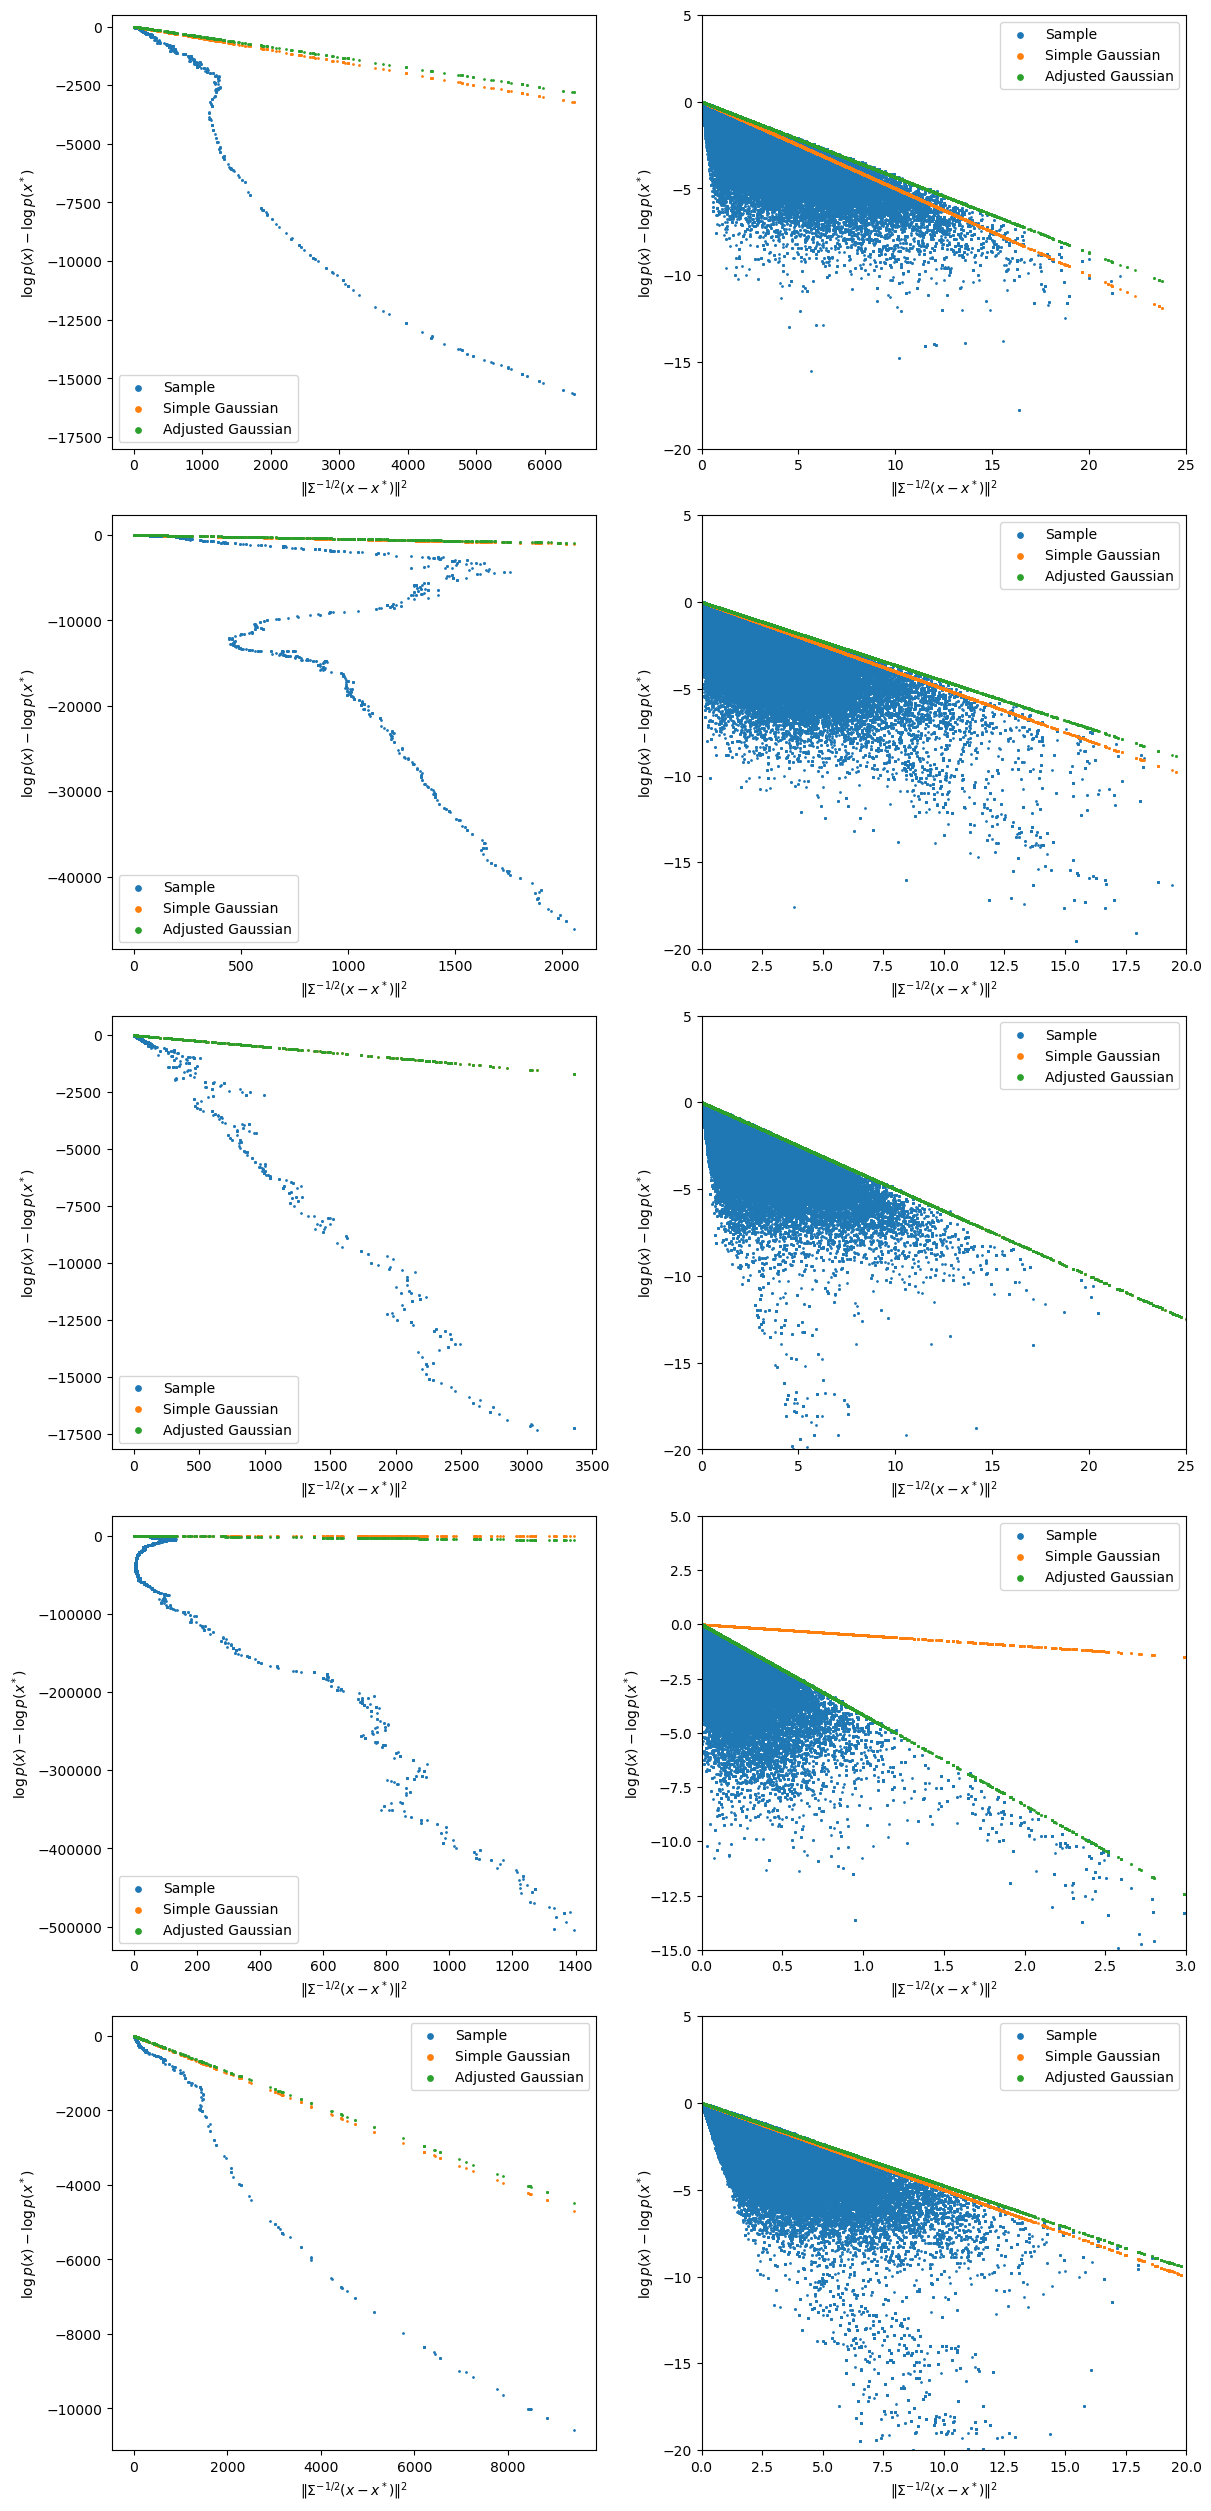

In [31]:
fig, axs = plt.subplots(lotka_volterra.n_chains, 2, figsize=(12, lotka_volterra.n_chains * 5), constrained_layout=True);
for i in range(lotka_volterra.n_chains):
    plot_chain(i, axs[i]);

Attempt to use the adjusted Gaussian distribution for thinning:

In [32]:
gaussian_thin(rw_samples[0], rw_log_p[0], fitted_mean, fitted_cov, n_points_thinned)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([367968, 278021, 283038, 149313, 181322, 263458,  12999, 312428,
       210376, 404701,  80507, 490046, 475597, 305430, 373009, 283038,
       427710, 401943, 367968, 294903], dtype=uint32)

In [33]:
@cached(batch_size=lotka_volterra.n_chains)
def rw_gf_adjusted_gaussian_idx(i) -> np.ndarray:
    sample = rw_samples[i]
    log_p = rw_log_p[i]
    sample_mean = np.mean(sample, axis=0)
    sample_cov = np.cov(sample, rowvar=False, ddof=lotka_volterra.d)
    return gaussian_thin(sample, log_p, sample_mean, sample_cov * cov_multipliers[i], n_points_calculate)

In [34]:
%%time
map_parallel(rw_gf_adjusted_gaussian_idx.get_or_recalculate, range(lotka_volterra.n_chains));

CPU times: user 43.6 ms, sys: 88.7 ms, total: 132 ms
Wall time: 2.73 s


Notebook execution took:

In [35]:
time.time() - start_time

254.16041684150696